# Libraries

In [1]:
# Numpy and Matplot
import numpy as np
import matplotlib.pyplot as plt

# Keras for TensorFlow
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.contrib.keras.python.keras.optimizers import Adam, RMSprop
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
# from tensorflow.contrib.keras.python.keras.applications.resnet50 import ResNet50

# OpenCV
import cv2

# Load training and validation sets

In [2]:
trainingset_x = np.load('gender/wiki_crop/64_64_50614_4098_training_x_onehot.npy')
trainingset_y = np.load('gender/wiki_crop/64_64_50614_4098_training_y_onehot.npy')

testingset_x = np.load('gender/wiki_crop/64_64_11938_4098_testing_x_onehot.npy')
testingset_y = np.load('gender/wiki_crop/64_64_11938_4098_testing_y_onehot.npy')

valset_x = np.load('gender/wiki_crop/64_64_5968_4098_val_x_onehot.npy')
valset_y = np.load('gender/wiki_crop/64_64_5968_4098_val_y_onehot.npy')

# Data processing

In [3]:
img_dim = 64
n_channels = 1
n_inputs = img_dim*img_dim
n_classes = 2

trainingset_x = trainingset_x.reshape(trainingset_x.shape[0], img_dim, img_dim)
trainingset_x = np.expand_dims(trainingset_x, axis=4)

testingset_x = testingset_x.reshape(testingset_x.shape[0], img_dim, img_dim)
testingset_x = np.expand_dims(testingset_x, axis=4)

valset_x = valset_x.reshape(valset_x.shape[0], img_dim, img_dim)
valset_x = np.expand_dims(valset_x, axis=4)

# Some useful functions

#### Get label from vector or number

In [4]:
def get_label(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'female'
    elif indx == 1:
        return 'male'

In [78]:
def predict_gender_from_image_file(file_name):
    img = cv2.imread(file_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.imshow(img, cmap='gray')
    plt.axis('off')

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (64, 64))

    img = cv2.transpose(img)
    img = img.reshape([1, img_dim, img_dim, 1])
    pred_cls = model.predict_classes(img, verbose=0)
    proba = model.predict(img, verbose=0)

#     print('> predicted gender: %s (%f%%)'
#           % (get_label(pred_cls), np.max(proba)))
    
    plt.title('predicted gender: ' + get_label(pred_cls) + ' (' + str(np.max(proba)) + '%)')
    plt.show()

#### Plot samples

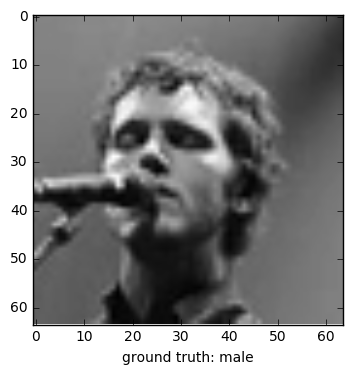

In [55]:
indx = 4000
img = trainingset_x[indx, :]
img = img.reshape([img_dim, img_dim])
img = np.transpose(img)
plt.imshow(img, cmap='gray')
plt.xlabel('ground truth: ' + get_label(trainingset_y[indx]))
plt.show()

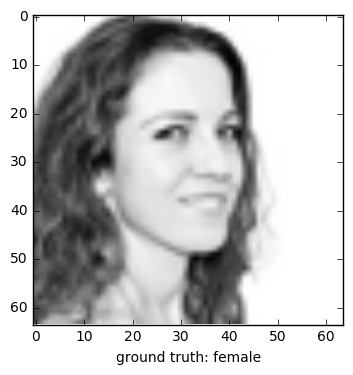

In [7]:
indx = 5200
img = valset_x[indx, :]
# img = img.reshape([img_dim, img_dim])
img = img.reshape([img_dim, img_dim])
img = np.transpose(img)
# plt.imshow(img)
plt.imshow(img, cmap='gray')
plt.xlabel('ground truth: ' + get_label(valset_y[indx]))
plt.show()

# Define CNN model using Keras + TensorFlow

#### A model in Keras + TensorFlow defined as a sequence of layers

In [8]:
model = Sequential()

#### Convolutional layers and max pooling layers

In [9]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 input_shape=(img_dim, img_dim, n_channels)))

In [10]:
model.add(Conv2D(64, (3, 3), activation='relu'))

In [11]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [13]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [14]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [15]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [16]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [17]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#### Fully connected layer

In [18]:
n_hidden_units = 2048

model.add(Flatten())
model.add(Dense(n_hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model

In [19]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training the model

In [20]:
batch_size = 256
n_epoches = 500

# Stop training when the validation loss does not change significantly in 20 epoches
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.fit(trainingset_x, trainingset_y,
          batch_size=batch_size, epochs=n_epoches,
          validation_data=(valset_x, valset_y),
          shuffle=True, callbacks=[early_stopping])

Train on 50614 samples, validate on 5968 samples
Epoch 1/500
50614/50614 [==============================] - 54s - loss: 1.0285 - acc: 0.6460 - val_loss: 0.5557 - val_acc: 0.7807
Epoch 2/500
50614/50614 [==============================] - 46s - loss: 0.5744 - acc: 0.7106 - val_loss: 0.4678 - val_acc: 0.8234
Epoch 3/500
50614/50614 [==============================] - 44s - loss: 0.5224 - acc: 0.7534 - val_loss: 0.4637 - val_acc: 0.8081
Epoch 4/500
50614/50614 [==============================] - 45s - loss: 0.4788 - acc: 0.7801 - val_loss: 0.3865 - val_acc: 0.8529
Epoch 5/500
50614/50614 [==============================] - 45s - loss: 0.4447 - acc: 0.8032 - val_loss: 0.3616 - val_acc: 0.8688
Epoch 6/500
50614/50614 [==============================] - 45s - loss: 0.4162 - acc: 0.8216 - val_loss: 0.3892 - val_acc: 0.8499
Epoch 7/500
50614/50614 [==============================] - 45s - loss: 0.3941 - acc: 0.8337 - val_loss: 0.3473 - val_acc: 0.8711
Epoch 8/500
50614/50614 [=======================

# Evaluating trained model

In [21]:
scores = model.evaluate(testingset_x[0:9413 + 1, :], testingset_y[0:9413 + 1, :])
print('%s for male: %f' % (model.metrics_names[1], scores[1]))

scores = model.evaluate(testingset_x[9413:, :], testingset_y[9413:, :])
print('%s for female: %f' % (model.metrics_names[1], scores[1]))

9414/9414 [==============================] - 4s     
acc for male: 0.947419
2525/2525 [==============================] - 1s     
acc for female: 0.749307


# Save trained model

In [22]:
model.save_weights('gender_hflip_female_v2.h5')
print('> model saved')

> model saved


# Test trained model with a random testing sample

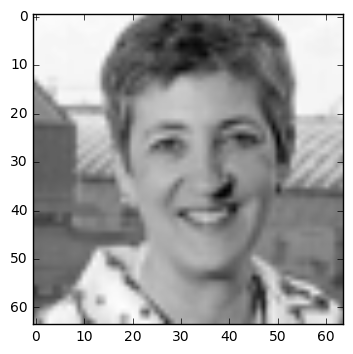

> testing image index: 11258
> true gender: female
> predicted gender: female


In [23]:
img_indx = np.uint32(np.random.rand()*(testingset_x.shape[0] - 1))
sample = testingset_x[img_indx, :]
sample = sample.reshape([1, img_dim, img_dim, 1])

pred_cls = model.predict_classes(sample, verbose=0)

sample = sample.reshape([img_dim, img_dim])
sample = np.transpose(sample)

plt.imshow(sample, cmap='gray')
plt.show()

print('> testing image index: %d\n> true gender: %s\n> predicted gender: %s'
      % (img_indx, get_label(testingset_y[img_indx, :]), get_label(pred_cls)))

# Test the trained model with personal images

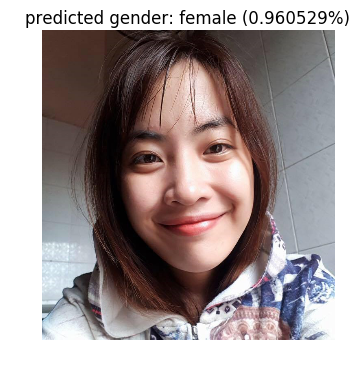

In [79]:
file_name = 'minh.jpg'
predict_gender_from_image_file(file_name)

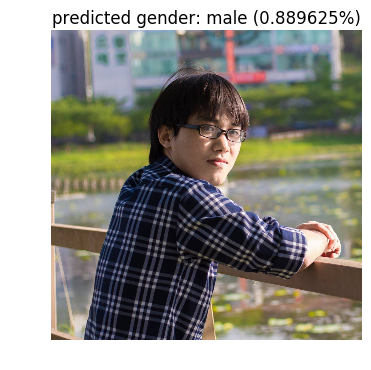

In [80]:
file_name = 'duong.jpg'
predict_gender_from_image_file(file_name)

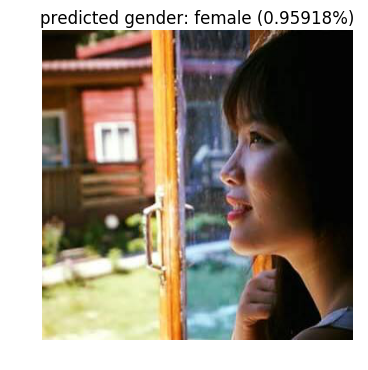

In [81]:
file_name = 'hang.jpg'
predict_gender_from_image_file(file_name)

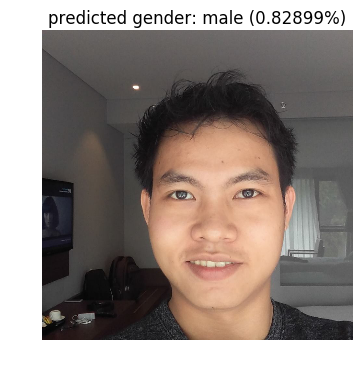

In [82]:
file_name = 'chinh.jpg'
predict_gender_from_image_file(file_name)

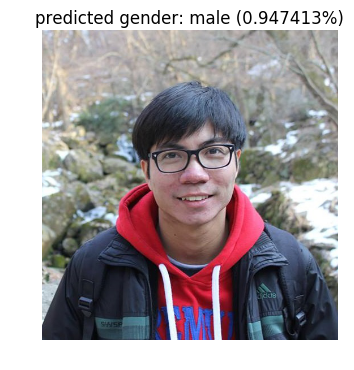

In [83]:
file_name = 'atoan.jpg'
predict_gender_from_image_file(file_name)

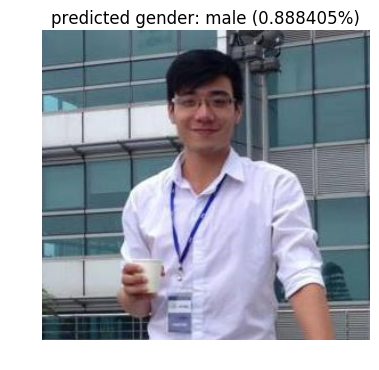

In [84]:
file_name = 'abao.jpg'
predict_gender_from_image_file(file_name)

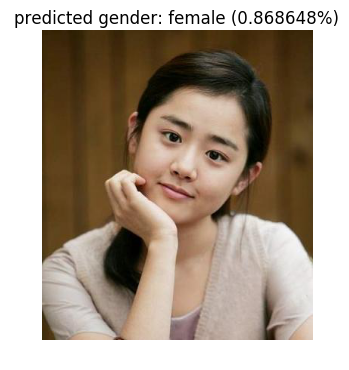

In [85]:
file_name = 'moon.jpg'
predict_gender_from_image_file(file_name)

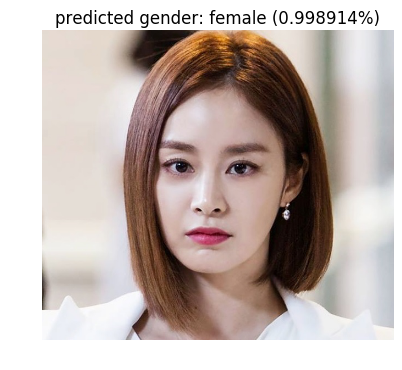

In [86]:
file_name = 'kim.jpg'
predict_gender_from_image_file(file_name)

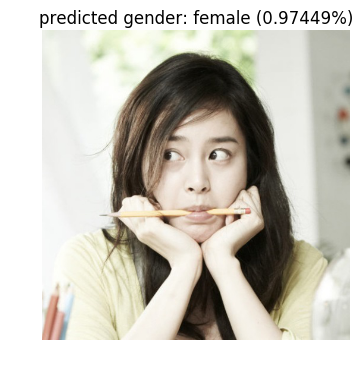

In [87]:
file_name = 'hee.jpg'
predict_gender_from_image_file(file_name)

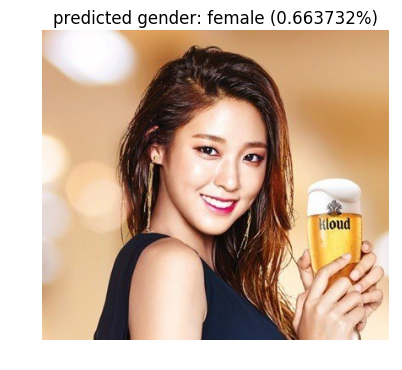

In [88]:
file_name = 'hyun.jpg'
predict_gender_from_image_file(file_name)

## Other test cases

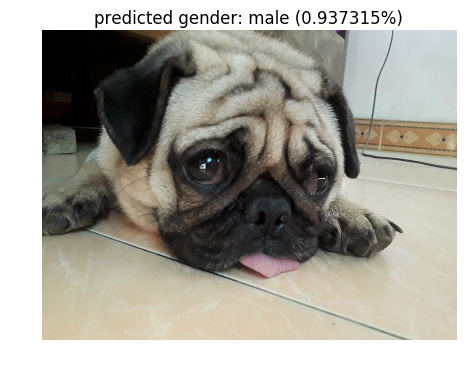

In [89]:
file_name = 'bun.jpg'
predict_gender_from_image_file(file_name)

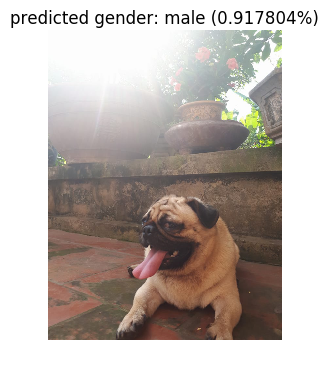

In [90]:
file_name = 'bun2.jpg'
predict_gender_from_image_file(file_name)